## Бутстрап
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва

В полученных подвыборках считаются статистики (среднее, медиана и т.п.)

Из статистик можно получить ее распределение и взять доверительный интервал

ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

# На нашем курсе по аналитике https://karpov.courses/ секцию про bootstrap читают ребята из https://www.experiment-fest.ru/
# Функция get_bootstrap взята из их занятия по АБ тестам

In [64]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95, # уровень значимости
    colname = ''
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
            
    pd_boot_data = pd.DataFrame(boot_data)*100
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    quants.columns = [str(statistic.__name__)]
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        bar.set_facecolor('grey')
        bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    #r = abs(statistic(data_column_1) - statistic(data_column_2))
    #plt.axvline(r,ymin=0,ymax=50,linestyle=':')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of " + colname)
    plt.show()
    
    print("Сред. разность: ", np.mean(boot_data))
    #print("Реал. разность: ", r)
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [65]:
data = pd.read_csv('data/all_data.csv', sep=',')
data = data.drop(['brow_a', 'brow_b', 'brow_c', 'brow_d'], axis=1)
data

,Асимметрия челюсти,Высота бровей,Наклон глаз,Полнота верхней губы,Полнота нижней губы,Асимметрия размера глаз,Ширина посадки глаз,Скулы,Форма головы,Верхнее веко,Асимметрия брови,Наклон бровей,Размер рта,Асимметрия наклона глаз,Асимметрия носа,Размер глаз,Оттопыренность ушей,Ширина челюсти,Уголки рта,Class
0,3.390337,0.155163,-7.744183,0.728999,5.310254,0.981586,0.720082,-1.353690,1.308804,0.349305,0.525278,11.811265,31.003218,-4.353457,-4.314198,4.716563,24.994238,0.893839,-1.834935,warrior
1,0.009935,0.225912,-9.292315,1.778055,5.545871,1.013628,0.817481,-6.867299,1.483796,0.820615,-0.836305,3.376133,42.581685,-0.997495,-1.984013,5.088016,12.242349,0.915261,35.596608,warrior
2,0.891460,0.141038,-12.152457,1.414088,6.599077,0.937218,0.739006,-0.005200,1.537365,0.550704,1.371180,20.424357,35.835962,1.669998,-0.466894,5.429823,18.854505,0.886362,9.021793,warrior
3,-2.407352,0.226568,2.480188,1.533930,7.669650,1.002826,0.859598,-2.441267,1.252503,0.766965,2.398082,12.194204,39.182829,1.828180,-2.996390,5.691325,14.572335,0.913848,-11.036772,warrior
4,0.626843,0.172757,-16.717817,1.956183,8.802824,0.991575,0.829462,15.776568,1.302185,0.236132,2.277609,19.178883,41.091489,1.575153,-0.538334,5.136880,8.802824,0.930010,2.726311,warrior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3183,-4.743319,0.159970,-12.518257,0.676581,5.936575,1.066776,0.826851,8.034751,1.343466,0.348165,0.390438,21.587770,35.898508,3.368687,0.097792,6.165936,4.775866,0.872903,28.489986,human
3184,-3.517170,0.277768,-5.068018,2.166255,8.317798,1.010103,0.942079,0.021125,1.536128,1.027160,0.194032,7.177718,39.614944,0.745327,-0.185093,5.853943,4.813901,0.866637,0.098037,human
3185,2.583132,0.197724,-10.422874,1.140166,9.679354,0.959467,0.912630,6.698992,1.459632,0.367528,-1.120887,19.736230,40.318836,-1.294121,-2.154311,5.969982,12.292417,0.853945,5.806727,human
3186,6.999978,0.224875,0.682060,1.138010,4.355265,0.976121,0.714384,21.841788,1.393747,0.599271,1.228379,10.462251,35.634731,0.682060,-2.289321,4.618274,20.148377,0.927516,8.585034,human


In [66]:
data_norm = data.copy()
for col in tqdm(data.columns[:-1]):
    data_norm[col] = (data_norm[col] - data_norm[col].quantile(0.001)) / (data_norm[col].quantile(0.999) - data_norm[col].quantile(0.001))
    

  0%|          | 0/19 [00:00<?, ?it/s]

<AxesSubplot:>

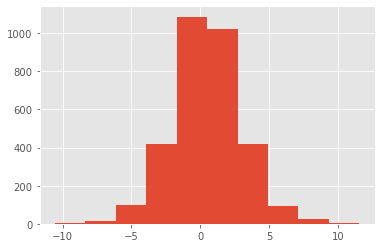

In [67]:
data['Асимметрия челюсти'].hist()

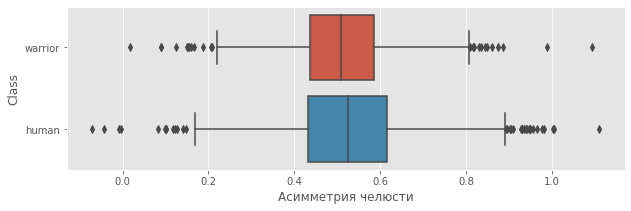

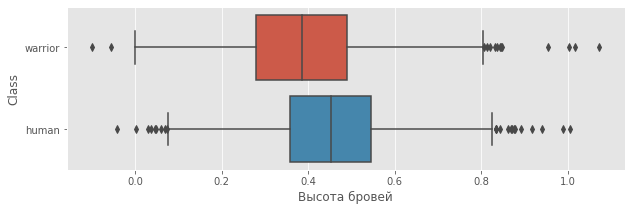

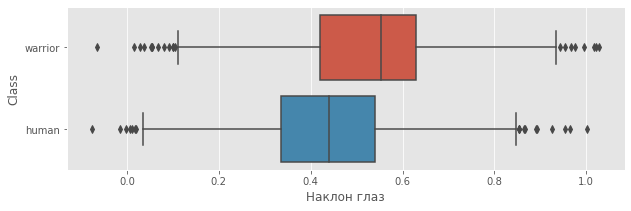

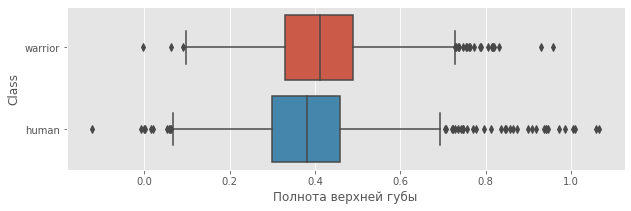

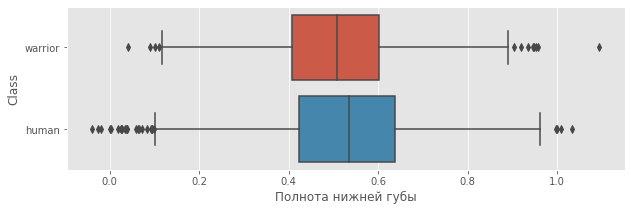

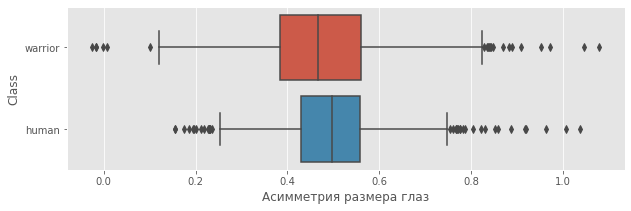

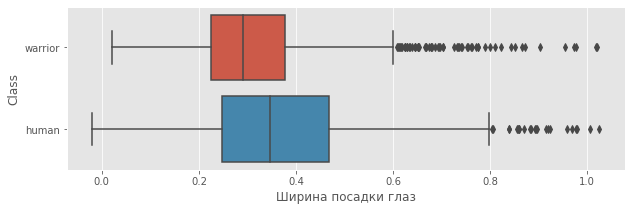

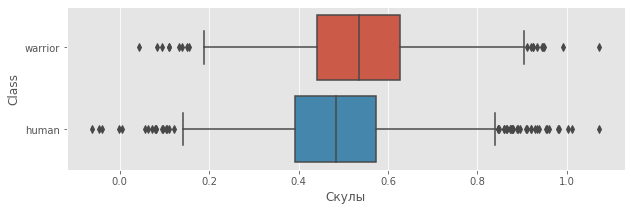

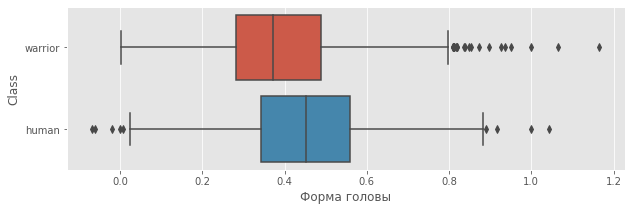

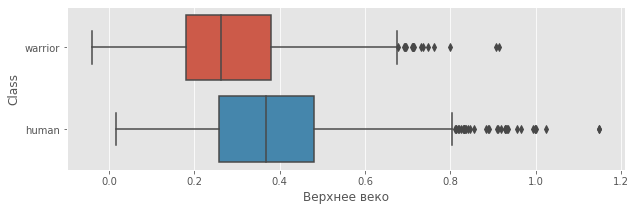

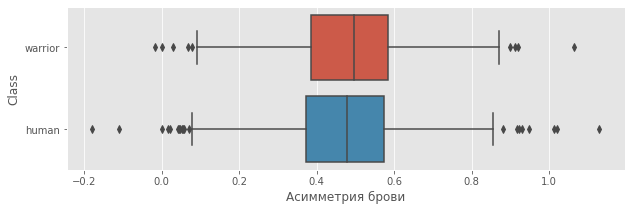

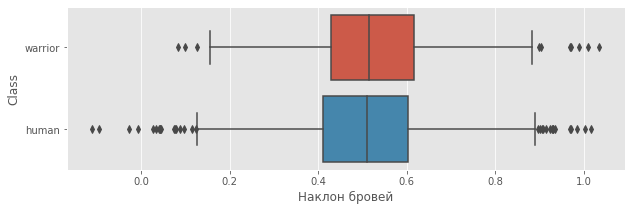

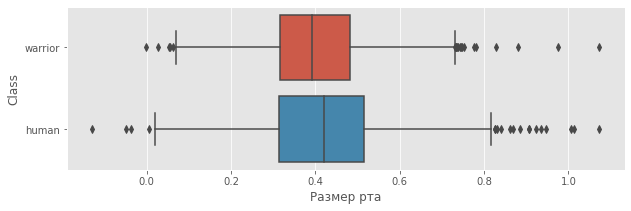

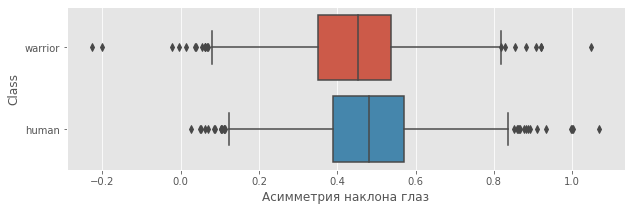

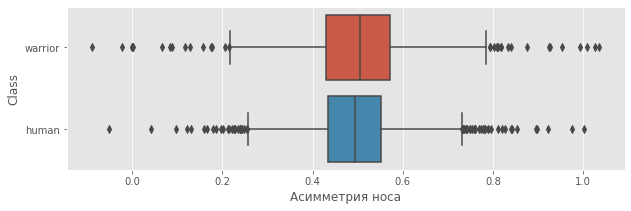

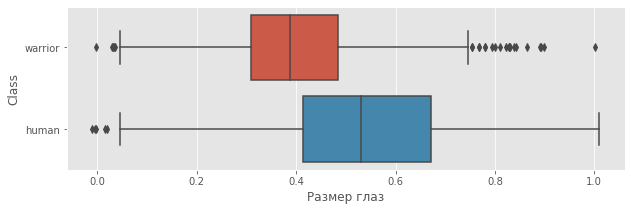

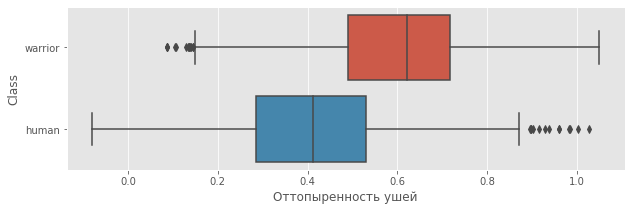

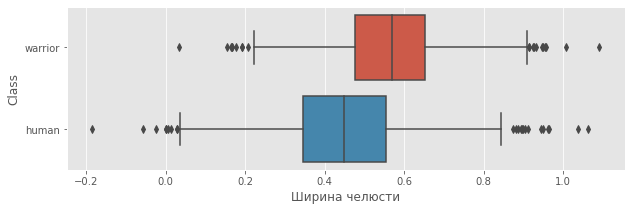

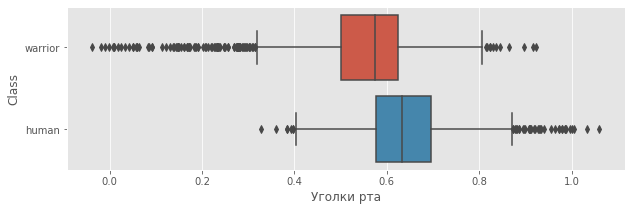

In [68]:
for i in data_norm.columns[0:19]:
    f, ax = plt.subplots(figsize=(10, 3))
    sns.boxplot(data=data_norm, x=i, y="Class")
    plt.show()

In [69]:
war = data_norm[data_norm.Class == 'warrior']
hum = data_norm[data_norm.Class == 'human']

  0%|          | 0/1000 [00:00<?, ?it/s]

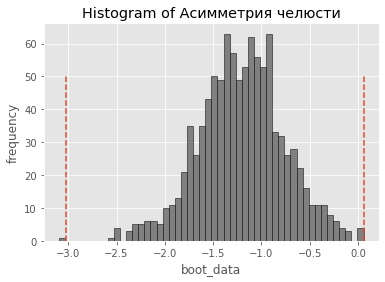

Сред. разность:  -0.012066924634197179
              mean
0.000132 -3.026979
0.999868  0.057640
p_value 0.006554697841077544 False


  0%|          | 0/1000 [00:00<?, ?it/s]

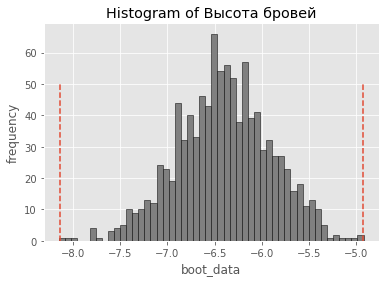

Сред. разность:  -0.06401787337562541
              mean
0.000132 -8.137014
0.999868 -4.926045
p_value 1.9316386668963998e-37 True


  0%|          | 0/1000 [00:00<?, ?it/s]

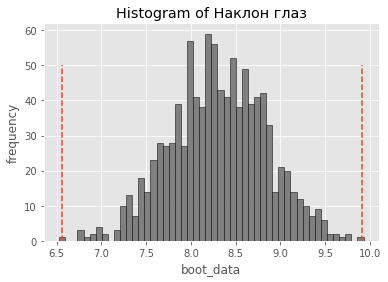

Сред. разность:  0.08306208280158174
              mean
0.000132  6.557345
0.999868  9.912123
p_value 6.076875151243012e-54 True


  0%|          | 0/1000 [00:00<?, ?it/s]

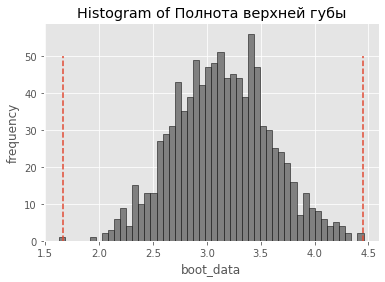

Сред. разность:  0.03141358265008437
              mean
0.000132  1.666990
0.999868  4.448827
p_value 1.5078699191013372e-12 True


  0%|          | 0/1000 [00:00<?, ?it/s]

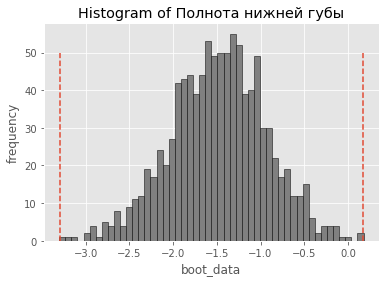

Сред. разность:  -0.014832960156217332
              mean
0.000132 -3.287747
0.999868  0.168314
p_value 0.006535405676208508 False


  0%|          | 0/1000 [00:00<?, ?it/s]

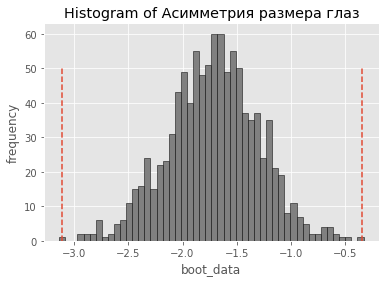

Сред. разность:  -0.01715900253561905
              mean
0.000132 -3.109159
0.999868 -0.351314
p_value 3.769114206466107e-05 True


  0%|          | 0/1000 [00:00<?, ?it/s]

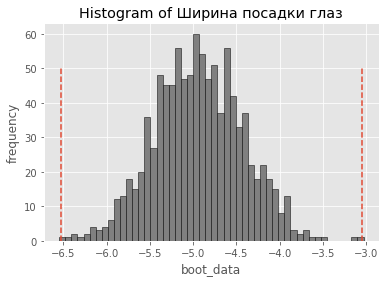

Сред. разность:  -0.04939770348483113
              mean
0.000132 -6.532407
0.999868 -3.048396
p_value 4.354375737119647e-22 True


  0%|          | 0/1000 [00:00<?, ?it/s]

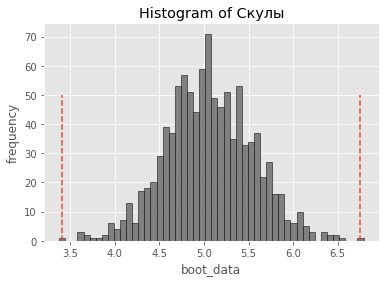

Сред. разность:  0.050592973112090614
              mean
0.000132  3.408038
0.999868  6.754943
p_value 4.708344231447668e-25 True


  0%|          | 0/1000 [00:00<?, ?it/s]

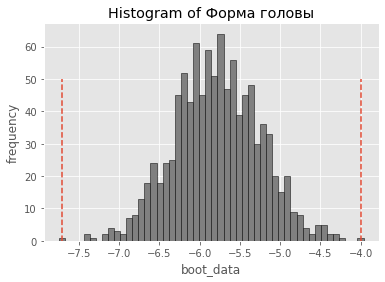

Сред. разность:  -0.05787854598589694
              mean
0.000132 -7.704312
0.999868 -3.999061
p_value 2.884389210107125e-27 True


  0%|          | 0/1000 [00:00<?, ?it/s]

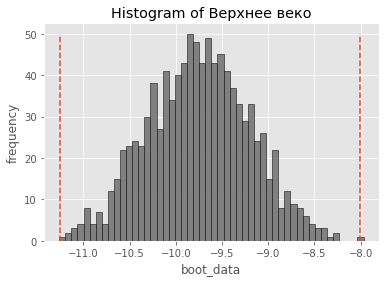

Сред. разность:  -0.09752525451265849
               mean
0.000132 -11.248963
0.999868  -8.008288
p_value 1.912138098243085e-69 True


  0%|          | 0/1000 [00:00<?, ?it/s]

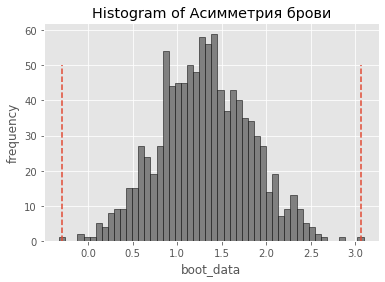

Сред. разность:  0.013058279493399369
              mean
0.000132 -0.293512
0.999868  3.059084
p_value 0.01027650526967128 False


  0%|          | 0/1000 [00:00<?, ?it/s]

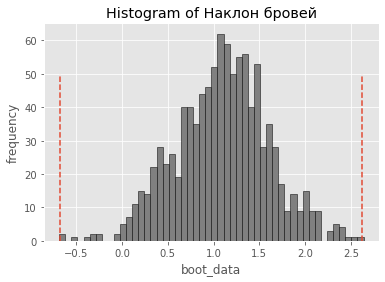

Сред. разность:  0.010948056441364833
              mean
0.000132 -0.681668
0.999868  2.623801
p_value 0.030173705660682257 False


  0%|          | 0/1000 [00:00<?, ?it/s]

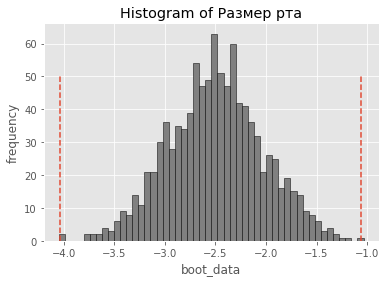

Сред. разность:  -0.024988269762199703
             mean
0.000132 -4.03967
0.999868 -1.05674
p_value 1.0559541411823953e-07 True


  0%|          | 0/1000 [00:00<?, ?it/s]

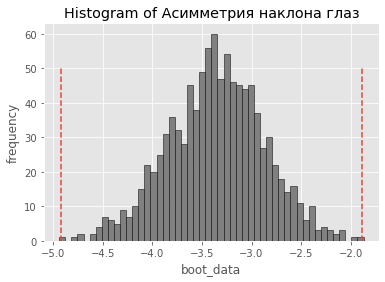

Сред. разность:  -0.03359668016229459
              mean
0.000132 -4.919695
0.999868 -1.886128
p_value 4.388392357408111e-12 True


  0%|          | 0/1000 [00:00<?, ?it/s]

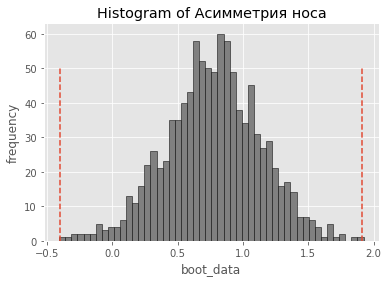

Сред. разность:  0.0077434945718632365
              mean
0.000132 -0.397320
0.999868  1.912508
p_value 0.032143910903206015 False


  0%|          | 0/1000 [00:00<?, ?it/s]

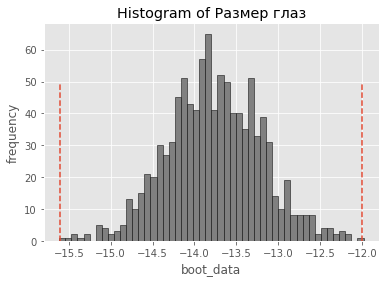

Сред. разность:  -0.1376688814183215
               mean
0.000132 -15.602133
0.999868 -12.002690
p_value 5.900129284912826e-133 True


  0%|          | 0/1000 [00:00<?, ?it/s]

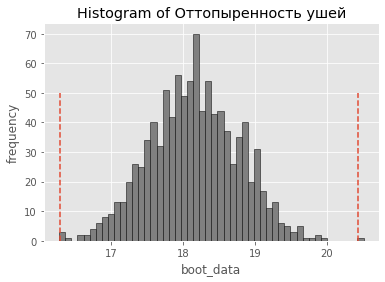

Сред. разность:  0.18157804790493579
               mean
0.000132  16.290781
0.999868  20.434536
p_value 2.5376862000652752e-189 True


  0%|          | 0/1000 [00:00<?, ?it/s]

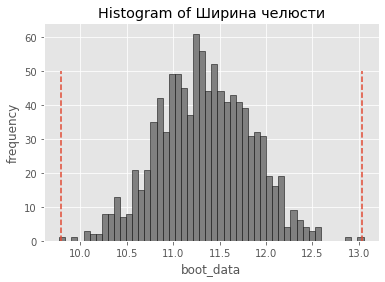

Сред. разность:  0.1133616435914823
               mean
0.000132   9.795841
0.999868  13.030893
p_value 4.923515033579739e-118 True


  0%|          | 0/1000 [00:00<?, ?it/s]

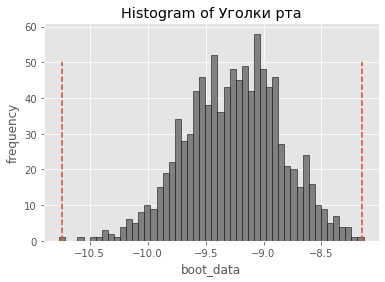

Сред. разность:  -0.0925842295514447
               mean
0.000132 -10.736952
0.999868  -8.147743
p_value 1.2694470283657045e-111 True


In [70]:
for i in data_norm.columns[0:19]:
    res = get_bootstrap(
        war[i], # числовые значения первой выборки
        hum[i], # числовые значения второй выборки
        boot_it = 1000, # количество бутстрэп-подвыборок
        statistic = np.mean, # интересующая нас статистика
        bootstrap_conf_level = 1 - (0.01 /38), # уровень значимости
        colname = i)
    print(res['quants'])
    print("p_value", res['p_value'], res['p_value'] < (0.01 /38))